# Ciąg dalszy zaprzyjaźniania się z rozkładem Gaussa

<img src="http://3.bp.blogspot.com/_fdejJGbaRV8/TASF_aLnAjI/AAAAAAAAAYk/UAayxJjArJs/s1600/Picture+69.png" width=600>

Jeśli popatrzymy na wzór opisujący wielowymiarowy rozkład Gaussa (a konkretnie na wartość wykładnika), to zobaczymy tam taki fragment:
$$(x-\mu)^T\Sigma^{-1}(x-\mu)$$

Zauważmy, że:
1. Można pozbyć się $\mu$ przesuwając wykres funkcji o $-\mu$ (powtórka z gimnazjum).
2. Zmienna $x$ występuje tylko w tym kawałku wzoru.

# Regresja liniowa

Jak zwykle proces modelowania danych zaczynamy od załóżenia czegoś o rozkładzie. Wcześniej, zakładaliśmy że ciąg obserwacji rzutów monetą jest dobrze modelowane ciągiem niezależnych zdarzeń, każde o rozkładzie Bernoulliego. Załóżmy teraz, że obserwujemy ciąg par (x_i, y_i) (patrz rysunek poniżej), oraz że każde y_i można całkiem dobrze przewidzieć z x_i za pomocą wzoru y_i = m*x_i + b + N(0, 1).

<img src="figures/L2/linear_reg.png">

[Ref: https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/lecture3.pdf]

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Cwiczenie 1 (1 pkt)

Dane pochodzą z rozkładu y_i = m*x_i + b + N(0, 1). Dla zadanego zbioru policz log-likelihood danych dla m=2.0 i b=0.1, gdzie loglikelihood =  $log \prod_i p(y_i | m, x_i) = \sum log p(y_i | m, x_i)$

Log likelihood:  -231.545040364


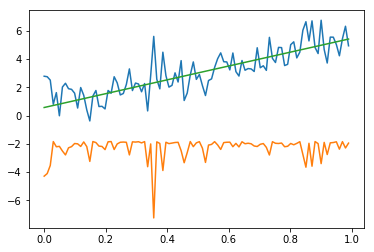

In [13]:
## Syntetyczny zbiór danych
np.random.seed(123456789)

def y(x,m,b,mu=0,sigma=1): 
    return m*x + b + np.random.normal(mu,sigma,1)[0]

N = 101
M = 2
t = np.empty(N)
domain_bound = 1.0/N
domain = np.empty(N)

for i in range(N): 
    domain[i] = i*domain_bound
    
for i in range(N): 
    t[i] = y(x=domain[i],m=4.89,b=0.57)


def logp(y_i, m, b, sigma, x_i):
    y_prop = m*x_i + b
#   p      = np.log(exp((-(y_i - y_prop)**2.0)/(2.0 ** sigma ** 2.0)) / np.sqrt(2 * sigma**2.0 * np.pi))
    p      = - np.log(2*np.pi) - np.log(sigma ** 2.0) - (1/(2.0 * (sigma**2.0))) * ((y_i - y_prop)**2.0)
    return p

llh = []
for d_i, y_i in zip(domain, t):
    llh.append(logp(y_i, 4.89, 0.57, 1.0, d_i))

_ = plt.plot(domain,t, domain, llh, domain, y(domain, 4.89, 0.57, mu=0, sigma=0.0001))

print "Log likelihood: ", np.sum(llh)

    

## Macierz dodatnio określona

W przestrzeni euklidesowej mamy dany kanoniczny iloczyn skalarny oraz pochodzącą od niego normę:
$$\|v\|^2 = \langle v,v \rangle$$
wtedy zbiór wektorów o długości jednostkowej to po prostu sfera.

Okazuje się, że możemy zdefiniować nieskończenie wiele różnych iloczynów skalarnych, a każdy z nich związany jest z pewną dodatnio określoną macierzą $A$:
$$\|v\|^2 = v^T A v$$

Jeśli za $A$ podstawimy $I$ (macierz identycznościową), to otrzymamy poprzedni wzór.

Dla różnych iloczynów skalarnych wektory długości jednostkowej układają się na elipsoidzie. Jej kształt (długość osi) oraz położenie (obrót) zależą tylko od macierzy $A$. Jeśli zamiast $A$ użyjemy macierzy odwrotnej $A^{-1}$ (macierz dodatnio określona jest odwracalna, a jej odwrotność też jest dodatnio określona), to otrzymamy elipsę o tak samo zorientowanych osiach, ale o odwrotnych długościach (zamiast 5 będzie $\frac15$ itp.).

### Uwaga dot. rysowania histogramów

W poniższych ćwiczeniach histogramy mają reprezentować gęstości rozkładów prawdopodobieństwa, dlatego podczas rysowania zawsze należy je normalizować.

## Ćwiczenie 2 (1 pkt)

Napisać funkcję, która przyjmuje dwuwymiarową dodatnio określoną macierz $A$, a następnie:
1. Rysuje heatmap dla $v^TAv$.
2. Na tym samym wykresie:
    - rysuje okrąg jednostkowy,
    - rysuje elipsę jednostkową dla $A$,
    - rysuje elipsę jednostkową dla $A^{-1}$.

Jedyną trudność może sprawić narysowanie elipsy jednostkowej. Proponuję zrobić to w następujący sposób:
1. Zacząć od listy wektorów na okręgu jednostkowym - punkty postaci $(\cos(\alpha), \sin(\alpha))$, gdzie $\alpha$ są rozmieszczone równomiernie na odcinku $[0,2\pi)$.
2. Dla każdego wektora $v$ liczymy $\|v\|^2 = v^TAv$ - chcielibyśmy, żeby $\|v\| = 1$, więc w tym celu wystarczy zastąpić $v$ przez $\frac{v}{\sqrt{v^TAv}}$.
3. Mamy listę kolejnych punktów leżących na elipsie jednostkowej macierzy $A$, rysujemy je i łączymy odcinkami.

Oczywiście najwygodniej będzie stworzyć funkcję pomocniczą draw_ellipse, której podamy kolejno macierz identycznościową (aby uzyskać okrąg), macierz $A$ i $A^{-1}$.

(400L, 400L)
(400L, 400L)
(400L, 400L)
[[ 1.    0.  ]
 [ 0.    0.25]]


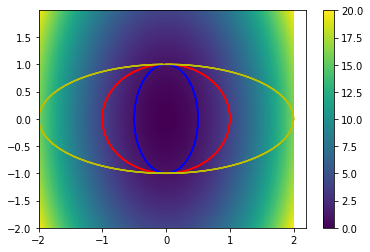

In [85]:
# Spodziewany efekt - albo mała elipsa wewnątrz okręgu wewnątrz dużej elipsy,
# albo duża i mała elipsa przecinają się dokładnie na okręgu

yy = []
xx = []
norm = []

A = np.array([[1.0, 0.0],
              [0.0, 4.0]])

for y in [(y/100.0-2.0) for y in range(0, 400)]:
    y_temp = []
    x_temp = []
    norm_temp = []
    
    for x in [(x/100.0-2.0) for x in range(0, 400)]: # range from -2.0 to 2.0
        v = np.array([[y], 
                      [x]])
        norm_temp.append((v.transpose().dot(A).dot(v))[0][0])
        
        x_temp.append(x)
        y_temp.append(y)
    
    yy.append(y_temp)
    xx.append(x_temp)
    norm.append(norm_temp)
    
xx   = np.array(xx)
yy   = np.array(yy)
norm = np.array(norm)

print xx.shape
print yy.shape
print norm.shape
    
plt.pcolormesh(xx, yy, norm)
plt.colorbar() 

def draw_elipse(MyA, color):
    
    y_elipse = []
    x_elipse = []
    
    for alpha in [(x*2.0*np.pi)/100.0 for x in range(0, 200)]:
        y_i = np.cos(alpha)
        x_i = np.sin(alpha)
        
        v_i = np.array([[y_i], 
                        [x_i]])
        
        norm_i = ((v_i.transpose().dot(MyA).dot(v_i))[0][0])
        v_i = v_i/np.sqrt(norm_i)
        
        y_elipse.append(v_i[0])
        x_elipse.append(v_i[1])
        
    plt.plot(x_elipse, y_elipse, color)
    
draw_elipse([[1,0],[0,1]], 'r-')
draw_elipse(A, 'b-')
print np.linalg.inv(A)
draw_elipse(np.linalg.inv(A), 'y-')
        

plt.show() 
    

## Wracamy do wzoru na gęstość

Wiemy już, że $(x-\mu)^T\Sigma^{-1}(x-\mu)$ oznacza "elipsową" odległość $x$ od $\mu$. Ponieważ ta odległość umieszczona jest ze znakiem minus pod funkcją wykładniczą, oznacza to, że w punkcie $x=\mu$ gęstość jest największa, natomiast przy uciekaniu $x$ do nieskończoności gęstość maleje wykładniczo. Poziomice gęstości to elipsy wyliczone z macierzy $\Sigma^{-1}$. Właśnie dlatego rozkład Gaussa ma taki, a nie inny kształt.

## Macierz kowariancji to faktycznie macierz kowariancji

Jeśli losujemy punkty z $n$-wymiarowego rozkładu Gaussa, to każdą współrzędną możemy traktować jako oddzielną zmienną losową. Zmienne te mogą być skorelowane - jeśli np. losujemy z dwuwymiarowego rozkładu Gaussa i współrzędne będą dodatnio skorelowane, to większa część elipsy (o której mowa powyżej) znajdzie się w pierwszej i trzeciej ćwiartce układu współrzędnych, ponieważ tam punkty mają zgodne znaki. Ujemna korelacja spowoduje, że elipsa obróci się tak, aby jej duża część znajdowała się w drugiej i czwartej ćwiartce układu współrzędnych (przeciwne znaki współrzędnych punktów). Brak korelacji będzie oznaczał, że osi elipsy ustawią się równolegle do osi układu współrzędnych.

Wzór na estymator macierzy kowariancji można znaleźć tu (oznaczony literą $\mathbf{Q}$):
https://en.wikipedia.org/wiki/Sample_mean_and_covariance

Proszę się zastanowić, jak wygląda wzór na $\mathbf{Q}_{i,j}$ dla ustalonych $i$ i $j$ - jest to po prostu estymator kowariancji dwóch zmiennych losowych.
Proszę się też zastanowić, jak wygląda wzór na $\mathbf{Q}_{i,i}$ dla ustalonego $i$ - jest to estymator wariancji.

## Ćwiczenie 2 (1 pkt)

Wylosować 1000 punktów z dwuwymiarowego rozkładu normalnego o losowej macierzy $\Sigma$. Następnie wyestymować kowariancje z próbki i porównać z macierzą kowariancji.

In [123]:
# Spodziewany wynik - powinno wyjść prawie to samo

sigma_org = [[1.2, 0.8], [0.6, 4.2]]
mean_org = np.random.rand(2, 1)

N = 1000

points = np.random.multivariate_normal(mean_org.ravel(), sigma_org, N)
mean = np.mean(points, axis=0).reshape(2, 1)
print "Orginal mean:\n", mean_org
print "Estimated mean:\n", mean


sum = [[0.0, 0.0], [0.0, 0.0]]

for point in points:
    point = np.array(point).reshape(2, 1)
    sum += (point - mean).dot((point - mean).transpose())
    
sum /= (float(N-1))

print 
print "Orginal sigma:\n", np.array(sigma_org)
print "Estimated sigma:\n", sum


Orginal mean:
[[ 0.45260053]
 [ 0.21830547]]
Estimated mean:
[[ 0.47124097]
 [ 0.20417002]]

Orginal sigma:
[[ 1.2  0.8]
 [ 0.6  4.2]]
Estimated sigma:
[[ 1.17123832  0.52911308]
 [ 0.52911308  4.11460788]]


Przypomnijmy teraz jeszcze kilka ważnych własności, które sprawiają, że rozkład Gaussa w naturalny sposób pojawia się w zastosowaniach praktycznych.

## Rozkład produktowy, rozkład brzegowy

Produkt jednowymiarowych rozkładów Gaussa jest wielowymiarowym rozkładem Gaussa. Kształt tego rozkładu to elipsa, której osi ustawione są wzdłuż osi kanonicznych (a więc nie każdy wielowymiarowy rozkład Gaussa jest produktem rozkładów jednowymiarowych). Długości osi elipsy są bezpośrednio związane z wariancjami rozkładów jednowymiarowych.

Rozkład brzegowy dowolnego wielowymiarowego rozkładu Gaussa jest rozkładem Gaussa.

Rozkład Gaussa można przesuwać, obracać i rozciągać (transformacje afiniczne), a wciąż będzie to rozkład Gaussa.

## Ćwiczenie 3 (1 pkt)

[Nieobowiazkowe w grupie S.J.] Wylosować dwie serie po 1000 punktów z dwóch różnych jednowymiarowych rozkładów Gaussa. Narysować histogramy. Następnie umieścić wyniki w tabeli 1000 na 2 i narysować rozkład produktowy (zaznaczyć wylosowane pary punktów na płaszczyźnie).

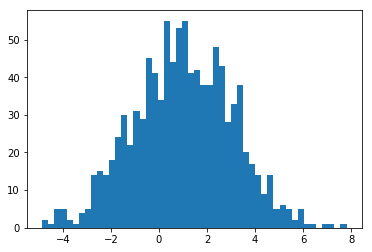

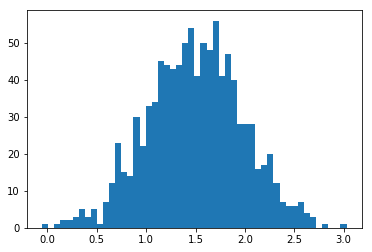

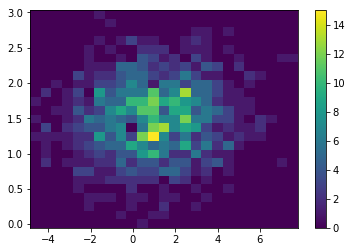

In [144]:
# spodziewany wynik - elipsa o osiach ustawionych równolegle do osi układu współrzędnych

normal1 = np.random.normal(1.0, 2.0, 1000)
normal2 = np.random.normal(1.5, 0.5, 1000)

plt.hist(normal1, 50)
plt.show()

plt.hist(normal2, 50)
plt.show()

normal2d = np.array([normal1, normal2]).transpose()

plt.hist2d(normal2d[:, 0], normal2d[:, 1], bins=25)
plt.colorbar()
plt.show()


## Ćwiczenie 4 (1 pkt)

[Nieobowiazkowe w grupie S.J.] Wziąć dane z poprzedniego ćwiczenia (tysiąc punktów na płaszczyźnie) i obrócić zbiór danych o kąt $\alpha$ (np. 43 stopnie) względem początku układu współrzędnych - w tym celu każdy wiersz tabeli z danymi należy przemnożyć przez macierz:
$$\begin{bmatrix}
    \cos(\alpha) & -\sin(\alpha) \\
    \sin(\alpha) & \cos(\alpha) \\
\end{bmatrix}$$

Narysować nowe punkty na płaszczyźnie.

Narysować histogramy rozkładów brzegowych (czyli wziąć pierwszą współrzędną wszystkich punktów i narysować dla niej histogram, potem analogicznie zrobić z drugą współrzędną). Sprawdzić (wizualnie), że rozkłady brzegowe są rozkładami Gaussa.

In [ ]:
# Assert:
# przyjąć alpha = Pi/2
# wtedy drugi rozkład brzegowy powinien być pierwszym rozkładem z poprzedniego ćwiczenia,
# a pierwszy rozkład brzegowy odbiciem symetrycznym względem zera drugiego rozkładu
# z poprzedniego ćwiczenia (dlaczego?)

## Ćwiczenie 5 (1 pkt)

[Nieobowiazkowe w grupie S.J.] Powtórzyć dwa poprzednie ćwiczenia, ale na początku wylosować po 1000 punktów z dwóch różnych rozkładów jednostajnych (pierwszy na odcinku $[a, b]$, drugi na odcinku $[c, d]$). Sprawdzić, że po obrocie rozkład brzegowy nie jest jednostajny.

In [ ]:
# Spodziewany efekt - rozkład brzegowy ma kształt trapezu.

Suma dwóch rozkładów Gaussa jest rozkładem Gaussa.

## Ćwiczenie 6 (1 pkt)

[Nieobowiazkowe w grupie S.J.] Wykorzystać dwie serie danych z ćwiczenia 2. w celu udowodnienia powyższej uwagi - stworzyć odpowiednią trzecią serię danych (jaką?) i narysować jej histogram. Sprawdzić wizualnie, że jest to rozkład Gaussa.

Powtórzyć dla serii danych z rozkładu jednostajnego (ćwiczenie 4.), przekonać się, że suma rozkładów jednostajnych nie jest rozkładem jednostajnym. 

In [ ]:
# Spodziewany efekt:
#  - histogram rozkładu Gaussa
#  - histogram w kształcie trapezu równoramiennego lub trójkąta

## Centralne Twierdzenie Graniczne

Wersja prawdziwa:
https://pl.wikipedia.org/wiki/Centralne_twierdzenie_graniczne

Wersja na nasze potrzeby:
Jeśli doda się do siebie dużo różnych zmiennych losowych, to ich suma zaczyna przypominać rozkład Gaussa. Zawsze.

## Ćwiczenie 7 (1 pkt)

"Udowodnić" powyższe twierdzenie w następujący sposób:
1. Wylosować $k$ serii po 1000 punktów z rozkładu jednostajnego na odcinku $[0,1]$.
2. Zsumować te rozkłady.
3. Narysować histogramy sumy np. dla $k = 1, 2, 3, 5, 10$.
4. (Dla odważnych) Zamiast sumy zastosować poprawny wzór z Wikipedii (od każdego rozkładu odjąć średnią, uśrednić arytmetycznie zamiast sumować, przypomnieć sobie wzór na $\sigma$ rozkładu jednostajnego na odcinku, podzielić przez $\frac{\sigma}{\sqrt{n}}$).

(1000L,)


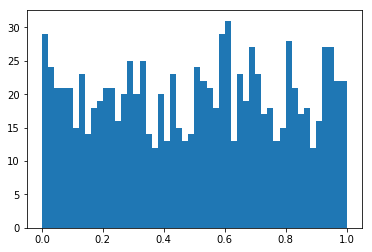

(2000L,)


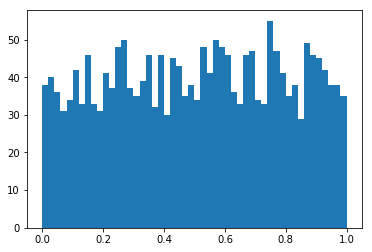

(3000L,)


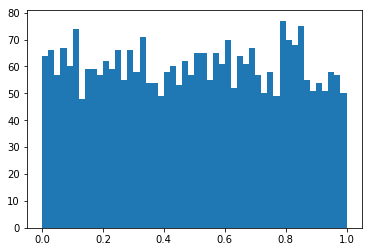

(5000L,)


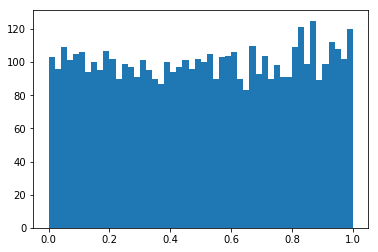

(10000L,)


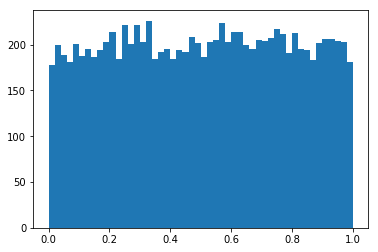

(50000L,)


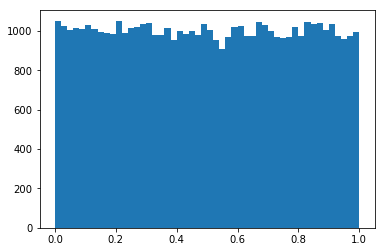

In [4]:
k_s = [1, 2, 3, 5, 10, 50]

for k in k_s:
    points = np.array([])
    for _ in range(k):
        points = np.concatenate((points, np.random.uniform(0.0, 1.0, 1000)), axis=0)
        
    points = np.array(points)
    print points.shape
        
    plt.hist(points, 50)
    plt.show()

### Więcej o rozkładzie normalnym

https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/lecture3.pdf